# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# # --------------------------
# # New packages to install if needed for mapping
# # --------------------------

# # Install plotly 
# !pip install plotly

# # Alternative is the geopandas library (which also needs descartes to work)
# !pip install git+git://github.com/geopandas/geopandas.git
# !pip install descartes

In [3]:
# --------------------------
# Load general numerical packages
# --------------------------
import numpy as np
import pandas as pd
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Load sklearn
# --------------------------
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics as metrics

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

# --------------------------
# Plotting
# --------------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

# --------------------------
# Other packages
# --------------------------
import statsmodels.api as sm
from statsmodels.api import OLS
from IPython.display import display

# --------------------------
# Mapping
# --------------------------
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

import geopandas as gpd

In [4]:
# increase display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Preparing the data: cleaning, resampling to achieve balanced classes, scaling etc
* **Part 2**: Developing maps to display the data
* **Part 3**: Exploring model performance metrics
* **Part 4**: Model tuning
* **Part 5**: Model comparisons



<div class='exercise'><b> Part 1: Preparing the data </b></div>

This notebook uses the cleaned CSV data file `data_cleaned_2016_2017.csv` downloaded from https://drive.google.com/open?id=1LCk-dDFC7O_6ek1i0IIGqE07Rq-kf1Xz. <br><br>

### Pre-processing the clean dataset

The cleaned dataset still needs some pre-processing in order to make it ready for modelling. This includes:

* Removing several more columns that are not informative, for example where they duplicate other information or only have a single value
* Drop the last digits of the zip code
* Recoding some ordinal variables into numerical scales
* Recoding some categorical variables into dummy variables

In [4]:
# read in the 2016-2017 data set
original_df = pd.read_csv('../../../data/data_cleaned_2016_2017.csv', low_memory = False)

In [6]:
# --------------------------
# Function to finalise data preparation
# --------------------------
def data_prep(df):
    '''Returns a cleaned up dataframe as basis for the EDA analysis
    Input:
        df: the pd.DataFrame object
    Returns:
        clean_df: pd.DataFrame object
    '''
    clean_df = df.copy()
    
    # --------------------------
    # Definitions
    # --------------------------
    cols_to_remove = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                      'mo_sin_rcnt_tl', 'funded_amnt', 'funded_amnt_inv', 'num_sats', 
                   'application_type', 'num_actv_rev_tl', 'pymnt_plan']
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
    prefixes = ['home', 'verify', 'purp', 'state']
    
    # --------------------------
    # Drop additional uninformative columns
    # --------------------------
    clean_df = clean_df.drop(columns=cols_to_remove)
    
    # --------------------------
    # Strip xx from zip code
    # --------------------------
    clean_df["zip_code"] = [x.strip("xx") for x in clean_df["zip_code"].astype(str)]
    clean_df["zip_code"] = clean_df["zip_code"].astype(int)
    
    # --------------------------
    # Exclude zip code from set of predictors for analysis
    # --------------------------
    # to be added back in later for checking discrimination...
    clean_df = clean_df.drop(columns='zip_code')

    # --------------------------
    # Ordinal columns are encoded as numerical values
    # --------------------------
    clean_df["grade"].replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}, inplace = True)
    clean_df["sub_grade"].replace({"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
                                "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
                                "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
                                "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
                                "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
                                "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
                                "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}, inplace = True)

    # --------------------------
    # Nominal columns are encoded via hot encoding by adding more columns
    # --------------------------
    clean_df = pd.get_dummies(clean_df, columns=nominal_columns, prefix=prefixes, drop_first=True)

    return clean_df

In [7]:
df_all = data_prep(original_df)

In [8]:
df_all.shape

(334109, 140)

### Resample to achieve balanced classes

Since we have imbalanced classes that can cause misleading assessment of model performance, we resample the classes here. We also take the opportunity to reduce the dataset size in the initial stages, so that different model specifications can be tested faster.

In [9]:
# Check balance of target values - it is unbalanced
df_all["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,255116
Charged Off,78993


In [10]:
# --------------------------
# Function to downsample and create balanced classes
# --------------------------

def balance_classes(df, n_samples, random_state = 1):
    # --------------------------
    # Define majority and minority classes
    # --------------------------
    df_majority = df[df["loan_status"] == "Fully Paid"]
    df_minority = df[df["loan_status"] == "Charged Off"]
    
    # --------------------------
    # Downsample majority and minority classes
    # --------------------------
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,   
                                     random_state = random_state) # set random seed for reproducability

    df_minority_downsampled = resample(df_minority, 
                                     replace = False,
                                     n_samples = n_samples,   
                                     random_state = random_state) 

    # --------------------------
    # Recombine
    # --------------------------
    df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

    return df_downsampled

In [11]:
# Define how many samples of each we want
n_samples = 5000 # Tune hyperparameters on a smaller sample size
df = balance_classes(df_all, n_samples)

In [12]:
df["loan_status"].value_counts().to_frame()

,loan_status
Charged Off,5000
Fully Paid,5000


### Scale the data and generate train/test splits

Since we will be using models that are sensitive to scale, we need to scale the data. This is done in a function for reproducability. The data is also split into training and test sets.


In [13]:
# Function to generate train test splits and scale the data
def get_train_test(df, test_size = 0.2, random_state = 1):
    nonbinary_columns = ['loan_amnt','int_rate','installment','grade','sub_grade','emp_length',
                         'annual_inc','issue_d','dti', 'delinq_2yrs','earliest_cr_line','inq_last_6mths', 
                         'open_acc','pub_rec','revol_bal','revol_util','total_acc', 'annual_inc_joint',
                         'dti_joint','acc_now_delinq','open_acc_6m','open_act_il', 'open_il_12m',
                         'open_il_24m', 'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                         'all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths',
                         'avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
                         'delinq_amnt','mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl',
                         'num_bc_sats','num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                         'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
                         'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                         'tax_liens', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_revol_util',
                         'sec_app_mths_since_last_major_derog']
    result = df.copy()
    
    # --------------------------
    # Train test split
    # --------------------------
    
    data_train, data_test = train_test_split(result, 
                                             test_size = test_size, 
                                             random_state = random_state,
                                            stratify = result.loan_status)
    X_train = data_train.iloc[:, data_train.columns != 'loan_status']
    y_train = data_train['loan_status']
    X_test = data_test.iloc[:, data_test.columns != 'loan_status']
    y_test = data_test['loan_status']
    
    # --------------------------
    # Extract unscaled variables for use later
    # --------------------------
    interest_rates = X_test["int_rate"].copy()
    earliest_credit = X_test["earliest_cr_line"].copy()
    
    # --------------------------
    # Scaling: Incorporate here so that we can use it consistently across all models
    # --------------------------
    
    scaler = StandardScaler()
    X_train[nonbinary_columns] = scaler.fit_transform(X_train[nonbinary_columns])
    X_test[nonbinary_columns] = scaler.transform(X_test[nonbinary_columns])
    
    
    # --------------------------
    # Recode loan status
    # --------------------------
  
    y_train = y_train.replace({'Fully Paid': 1, 'Charged Off': 0})
    y_test = y_test.replace({'Fully Paid': 1, 'Charged Off': 0})
    
    return X_train, y_train, X_test, y_test, earliest_credit

In [14]:
# Create scaled train and test sets
# plus extract the scaler to use in later reverse transforms
X_train, y_train, X_test, y_test, earliest_credit = get_train_test(df)


In [15]:
y_train.value_counts().to_frame()

,loan_status
1,4000
0,4000


<div class='exercise'><b> Part 2: Mapping </b></div>

### Using maps to display the data

This may come in useful later on when presenting the results, or as part of the EDA. The maps show that there is variation of the charge-off rate across the different States, with higher rates tending to be in the Eastern States. 

Resources used:
* Some example code on how to use Geopandas http://darribas.org/gds15/content/labs/lab_03.html 
* Downloadable shape files for the US: https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip


In [17]:
# --------------------------
# Set up data to be mapped
# --------------------------
# Recode loan status
original_df["loan_status"] = original_df["loan_status"].replace({'Fully Paid': 1, 'Charged Off': 0})

# Aggregating data by State
default_rate = 1 - original_df.groupby(["addr_state"]).mean()["loan_status"]

### Plotly: interactive map

This code generates an interactive map of charge-off rates by State.

In [18]:
# --------------------------
# Set up inputs for the map using plotly
# --------------------------
data = [ dict(
        type = 'choropleth',
        locations = default_rate.index,
        z = default_rate, 
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Default rate")
        ) ]

layout = dict(
        title = 'Average Charge off rate by State',
        geo = dict(
            scope = 'usa',
            projection = dict(type = 'albers usa' ),
            showlakes = True, 
            lakecolor = 'rgb(255, 255, 255)'),)
    

In [19]:
# --------------------------
# Create map using plotly
# --------------------------
fig = dict(data = data, 
           layout = layout)
iplot(fig, filename = 'cloropleth-map')

### Static maps using shape files

This part uses the shape files from the US census website

In [20]:
# --------------------------
# Create map using shape files 
# --------------------------

# Read in the shape files with geopandas
path = "../../shape_files/cb_2017_us_state_500k.shp" # census files
#path = "../../shape_files/states.shp"
states_map = gpd.read_file(path)

# Remove any states that aren't in the LendingClub data
states_map2 = states_map[states_map["STUSPS"].isin(list(original_df["addr_state"]))]

# Join the map data with the default rate
mapping_data = states_map2.join(default_rate, on = "STUSPS")
#mapping_data.head()

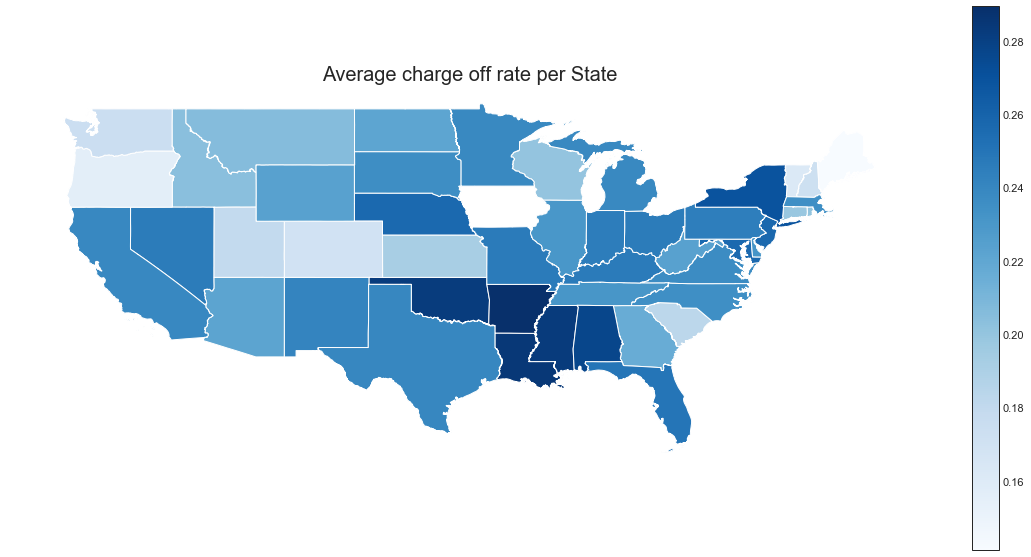

In [21]:
# Plot 
fig, ax = plt.subplots(1, figsize = (20, 10))
ax = mapping_data[mapping_data['NAME'].isin(['Alaska','Hawaii']) == False].plot(axes = ax, 
                       column = "loan_status",
                       cmap = "Blues", legend = True)

ax.axis('off')
#fig.tight_layout()
ax.set_title('Average charge off rate per State', fontdict = {'fontsize': '20', 'fontweight' : '3'});

<div class='exercise'><b> Part 3: Model performance metrics </b></div>

In this section, we explore several customised performance metrics to be used in our project. We also develop a wrapper function that will allow for multiple models to be trained and tested according to different performance metrics

### Custom performance metrics
This section develops custom scoring metrics that are needed for our project. These refer to:
* __Fairness metrics__: used to evaluate any potential differences in outcomes for a protected group vs unprotected group
* __Expected return__: used to calculate the expected return on investment from using each strategy

### Fairness metrics

We explored the possibility of implementing the IBM 360 fairness libraries in our project, as these seemed to offer the functionalities needed. Unfortunately we were unable to get the library to work without errors in the context of our project. 

Therefore, we implemented a selection of the fairness metrics directly in the function below. This calculates the following metrics for each model:

* __Equal opportunity__: the difference between the ratio of true positives to positive examples for the protected vs unprotected groups
* __Predictive equality__: the difference in accuracy of predictions for the protected vs unprotected groups
* __Statistical parity__: the difference in proportion of positive classifications in the protected vs unprotected groups


In [22]:
# --------------------------
# Create a custom scoring function that calculates fairness metrics
# -------------------------- 
def fairness_report(y_test, y_test_pred, protected_class):
    """Adapted from IBM360 Research.
        Calculates various fairness metrics:
        
        - Equal opportunity: Return the ratio of true positives to positive examples `TPR = TP/P`
        - Predictive equality: We define the predictive equality as the situation when accuracy 
        of decisions is equal across race groups, as measured by false positive rate (FPR). 
        - Statistical parity: Statistical parity denotes an equal proportion of each protected category in question are positively classified
        
        Returns: Metric differences between priviliged and unpriviliged groups:
        Equal opportunity, Predictive equality, Statistical parity
    """
    protected = np.where(X_test[protected_class] == 1) # Select protected class
    not_protected = np.where(X_test[protected_class] == 0) # Select unprotected class
    
    # --------------------------
    # Calculate metrics for protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[protected], y_test_pred[protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP
    
    TPR_protected = TP / P
    FPR_protected = FP / N
    Parity_protected = (TP + FP) / len(y_test.values[protected])
    
    # --------------------------
    # Same for un-protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[not_protected], y_test_pred[not_protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP    
    
    TPR = TP / P
    FPR = FP / N
    Parity = (TP + FP) / len(y_test.values[not_protected])
    
    results = pd.Series({"equal_opportunity": np.round(TPR_protected - TPR, 3),
               "predictive_equality": np.round(FPR_protected - FPR, 3),
               "statistical_parity": np.round(Parity_protected - Parity, 3)
        
    })
    
    return results
    

In [23]:
# Develop a quick classifier to play with
test_model = LogisticRegression(penalty = "l2").fit(X_train, y_train)
y_test_pred = test_model.predict(X_test.values)

In [24]:
protected_class = "term" # define protected class for practice - needs to be replaced
fairness_report = fairness_report(y_test, y_test_pred, protected_class)
fairness_report

equal_opportunity     -0.316
predictive_equality   -0.246
statistical_parity    -0.319
dtype: float64

### Expected return metric 

The code below implements a simple calculation of the expected return from each investment strategy (as defined by the classification models). It assumes that:
* $100 is invested in each loan
* The investor gains the interest on the loan, minus Lending Club's fees, if the loan is paid back
* The investor gains the total payments plus any recoveries if the loan is charged off

In [49]:

# --------------------------
# Import the complete set of data files
# -------------------------- 
Q1_2017 = pd.read_csv('../../../data/LoanStats_2017Q1.csv',low_memory=False,skiprows=1)
Q2_2017 = pd.read_csv('../../../data/LoanStats_2017Q2.csv',low_memory=False,skiprows=1)
Q3_2017 = pd.read_csv('../../../data/LoanStats_2017Q3.csv',low_memory=False,skiprows=1)
Q4_2017 = pd.read_csv('../../../data/LoanStats_2017Q4.csv',low_memory=False,skiprows=1)

Q1_2016 = pd.read_csv('../../../data/LoanStats_2016Q1.csv',low_memory=False,skiprows=1)
Q2_2016 = pd.read_csv('../../../data/LoanStats_2016Q2.csv',low_memory=False,skiprows=1)
Q3_2016 = pd.read_csv('../../../data/LoanStats_2016Q3.csv',low_memory=False,skiprows=1)
Q4_2016 = pd.read_csv('../../../data/LoanStats_2016Q4.csv',low_memory=False,skiprows=1)

Year_2016_2017 = pd.concat([Q1_2017,Q2_2017,Q3_2017,Q4_2017,Q1_2016,Q2_2016,Q3_2016,Q4_2016])

In [51]:
df_return = Year_2016_2017.loc[Year_2016_2017['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [53]:
# Select relevant data - added recoveries (post charge-off gross recovery)
result = df_return[['loan_amnt','int_rate','loan_status','total_pymnt', 'recoveries', 'collection_recovery_fee']]

In [54]:
result.head()

,loan_amnt,int_rate,loan_status,total_pymnt,recoveries,collection_recovery_fee
3,14000.0,15.99%,Charged Off,4804.100000,1765.55,317.799
8,3600.0,7.49%,Fully Paid,3765.098751,0.00,0.000
13,5000.0,14.99%,Fully Paid,5168.906377,0.00,0.000
14,10150.0,7.24%,Fully Paid,10941.319984,0.00,0.000
20,20000.0,12.74%,Charged Off,7356.870000,0.00,0.000


In [55]:
# --------------------------
# Make adjustments to dataframe
# -------------------------- 

result['Recieved'] = (result['total_pymnt'] + result['recoveries'] - result['collection_recovery_fee'] ) / result['loan_amnt'] *100
result['Recieved'].astype(float)
result['Gain loss'] = (result['Recieved'] - 100)
result['int_rate'] = result['int_rate'].str[:-1].astype(float)
result['int_round'] = result['int_rate'].round(0).astype(int)

In [56]:
# --------------------------
# Find the stats for the loans that gets charged off
# The investor experience an average loss of 55 % of each loan that gets charged off
# -------------------------- 
result[result['loan_status']=='Charged Off']['Gain loss'].describe()

count    80804.000000
mean       -54.759633
std         22.614079
min       -100.000000
25%        -70.653608
50%        -56.776072
75%        -40.967696
max        334.060000
Name: Gain loss, dtype: float64

In [57]:
# --------------------------
# Calculate investors return if the investor invests $100 in each of the 334109 loans
# -------------------------- 

gb = result[['int_round', 'Gain loss']].groupby(['int_round']).sum()

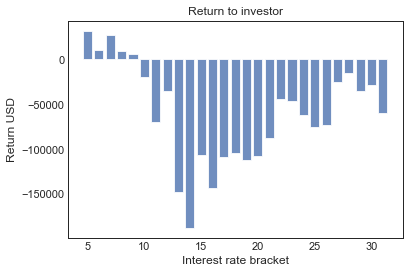

In [58]:
plt.title('Return to investor')
plt.bar(gb.index, gb['Gain loss'], align='center', alpha=0.8)
plt.ylabel('Return USD')
plt.xlabel('Interest rate bracket');

In [60]:
# --------------------------
# Calculate investors return if the investor invests $100 in 100 loans of each interest rate bracket
# -------------------------- 

dg = result.groupby('int_round')['int_round','Gain loss'].head(100)
ds = dg[['int_round', 'Gain loss']].groupby(['int_round']).sum()

In [26]:
# --------------------------
# Create a custom scoring function that calculates expected return
# -------------------------- 
        
def expected_return(y_test, y_test_pred):
    # --------------------------
    # Asusmptions
    # -------------------------- 
    amount_per_loan = 100 # Assue we invest $100 in every loan
    loss_rate = 0.5 # Assume that we lose 50% of the investment for each charged off loan
    LC_rate = 1 # Lending club fees of 1%
    
    # --------------------------
    # Get index of true positivies, TP and false positives, FP
    # -------------------------- 
    TP = (y_test_pred == 1) & (y_test == 1)
    FP = (y_test_pred == 1) & (y_test == 0)
    
    # --------------------------
    # Calculate gain from loans paid back and loss for charged off loans
    # --------------------------     
    gain = sum(amount_per_loan * (interest_rates[TP].values - LC_rate)/100)
    loss =  loss_rate * amount_per_loan * sum(FP)
    net = gain - loss
    
    return net

# --------------------------
# Turn this into a custom scorer
# -------------------------- 
expected_return_score = make_scorer(expected_return, greater_is_better=True)


In [27]:
# Try it out on the logistic model... leads to a big loss. 
# Oyvind to look at this

expected_return(y_test, y_test_pred)

-10708.860000000033

### Overview of performance metrics used for tuning hyperparameters

Since the cost of a false positive is relatively high, this needs to be accounted for when choosing the best model, while still aiming for a good overall performance. For the purposes of this project, we consider several metrics:

* __Precision__ = True positive / (True positive + False positive). Precision represents how precise the model is in predicting positive values, and is a good metric to use when the cost of false positives is high, as in our case. 
* __Recall__ = True positive / (True positive + False negative). Recall represents how many of the actual positives were correctly picked up by the model. It is important to use when the cost of false negatives is high. 
* __F1 score__ = harmonic mean of precision and recall. There is typically a trade-off between precision and recall and F1 therefore seeks to create a balance between these two metrics. 
* __ROC__ = The ROC plots the true positive rate (sensitivity) against the false positive rate (1-specificity) and therefore shows the trade-offs between the two.
* __AUC__ = Area under the ROC curve. The AUC for a classifier with no power (random guessing) is 0.5. If the AUC is 0.7, it means there is 70% chance that model will be able to distinguish between positive class and negative class.

In [28]:
# --------------------------
# Define scores to use
# --------------------------
scoring = {
    "AUC": "roc_auc", # Area under the curve
    "precision_score": make_scorer(precision_score),
    "recall_score": make_scorer(recall_score),
    "accuracy_score": make_scorer(accuracy_score),
    "f1_score": make_scorer(f1_score)
}

### Developing a wrapper function to optimise model hyper parameters according to a specified metric

When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. 

Setting refit_score = 'AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score. Other metrics could also be used. 

In [29]:
# --------------------------
# Function that use GridSearchCV to find the model with the best parameters 
# According to the specified "refit score"
# --------------------------
def grid_search_wrapper(clf, param_grid, refit_score = "AUC"):  
    '''
    Finds the optimal model according to "refit score" using GridSearchCV
    Prints model performance metrics
    Input:
        clf: the classification model
        param_grid: grid of parameters to search over
        refit_score: AUC or precision_score
    Returns:
        grid_search: fitted model object
    '''
    # --------------------------
    # Fit the classifier model
    # --------------------------
    grid_search = GridSearchCV(clf, 
                               param_grid, 
                               scoring = scoring, 
                               refit = refit_score,
                               cv = 5, 
                               return_train_score = True, 
                               n_jobs = -1 # Parallel processing
                              )  
    grid_search.fit(X_train.values, y_train.values)
    best_model = grid_search.best_estimator_
    all_scores = grid_search.cv_results_

    # --------------------------
    # Review parameters and performance for best model
    # --------------------------
    y_test_pred = grid_search.predict(X_test.values)
    y_test_pred_prob = grid_search.predict_proba(X_test)[:,1]
    print("Best params for {}".format(refit_score))
    print(grid_search.best_params_)
    print("Best score:", np.around(grid_search.best_score_, 2))
    print("Range", np.around(max(all_scores["mean_test_"+refit_score]), 2), np.around(min(all_scores["mean_test_"+refit_score]), 2))

    # --------------------------
    # Print confusion matrix (test data)
    # --------------------------
    print("\nConfusion matrix of model optimized for {} on the test data:".format(refit_score))
    display(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=["pred_neg", "pred_pos"], index=["neg", "pos"]))
    
    # --------------------------
    # Print classification report
    # --------------------------
    print("\nClassification report for best model:")
    print(classification_report(y_test, y_test_pred, digits = 2))

    
    return grid_search

In [ ]:
# --------------------------
# Function to generate the plots
# --------------------------

def plot_scorers(model, param_to_plot):
    results = model.cv_results_ # Get the CV results to show error bars
    best_model = model.best_estimator_
    
    # --------------------------
    # Retrieve predicted probabilities for the best model &
    # Get performance for different thresholds
    # --------------------------
    y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
    F1 = 2*(p[:-1]*r[:-1]) / (p[:-1]+r[:-1])
    
    # --------------------------
    # Plots the first two scorers - AUC and precision
    # --------------------------
    gridsize = (3, 2)
    fig = plt.figure(figsize = (9, 10))
    ax0 = plt.subplot2grid(gridsize, (0, 0), colspan = 2, rowspan = 2)
    ax1 = plt.subplot2grid(gridsize, (2, 0))
    ax2 = plt.subplot2grid(gridsize, (2, 1))

    ax0.set_title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize = 16)

    ax0.set_ylim(0.6, 0.8) # Zoom in so that differences can be seen
    ax0.set_xlabel(str(param_to_plot))
    ax0.set_ylabel("Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_"+str(param_to_plot)].data, dtype = float)

    # Plot the first two scorers
    for scorer, color in zip(scoring, ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax0.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == "test" else 0, color=color)
            ax0.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax0.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax0.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    ax0.legend(loc = "best");

    # --------------------------
    # Make graphs to show ROC and Precision-recall curves
    # --------------------------

    # ROC plot
    ax1.set_title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_prob))
    ax1.plot(fpr, tpr, "b")
    ax1.plot([0,1], [0,1], "r--")
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate");

    # Precision-recall plot
    ax2.set_title("Precision and Recall Scores as a function of the decision threshold")
    ax2.plot(thresholds, p[:-1], "b--", label = "Precision")
    ax2.plot(thresholds, r[:-1], "g-", label = "Recall")
    ax2.plot(thresholds, F1, "k", label = "F1 score")
    ax2.set_ylim([0,1])
    ax2.set_ylabel("Score")
    ax2.set_xlabel("Decision Threshold")
    ax2.legend(loc = "best");
    
    fig.tight_layout()

<div class='exercise'><b> Part 4: Model tuning </b></div>

### Find the best model of each type

This section develops a process to search through a grid of tuning parameters using the wrapper functions shown above and return the best models.

In [35]:
# --------------------------
# Function to run grid search, generate graphs and return the best model
# -------------------------- 

def trial_model(model, refit_score = "AUC", param_to_plot = "Default"):
    print("--------------------------")
    print(model["name"])
    print("--------------------------")

    grid_search = grid_search_wrapper(model["clf"], model["parameter_grid"], 
                                      refit_score = refit_score)
    if param_to_plot == "Default":
        param_to_plot = list(model["parameter_grid"])[0]

    plot_scorers(model = grid_search, 
                 param_to_plot = param_to_plot)
    return grid_search.best_estimator_


In [36]:
# --------------------------
# Create dictionaries for each model 
# -------------------------- 

Logistic = {"name": "Logistic",
            "clf": LogisticRegression(penalty = "l2"),
            "parameter_grid": {"C": np.logspace(-5, 0.5, 5)}
           }
RandomForest = {"name": "RandomForest",
                "clf": RandomForestClassifier(max_depth = 15, n_estimators = 400, n_jobs = -1),
                "parameter_grid": {"max_features": [2, 4, 6],
                                  "min_samples_split": [5, 9, 12]}
               }
AdaBoost = {"name": "Adaboost",
            "clf": AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1)),
           "parameter_grid": {"n_estimators": [50 * x for x in range(1, 5)]}}
Gradient = {"name": "Gradient",
           "clf": GradientBoostingClassifier(n_estimators = 400),
           "parameter_grid": {"max_features": [0.4, 0.5, 0.6]}}


--------------------------
Logistic
--------------------------
Best params for AUC
{'C': 0.005623413251903491}
Best score: 0.72
Range 0.72 0.7

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,647,353
pos,340,660



Classification report for best model:
             precision    recall  f1-score   support

          0       0.66      0.65      0.65      1000
          1       0.65      0.66      0.66      1000

avg / total       0.65      0.65      0.65      2000



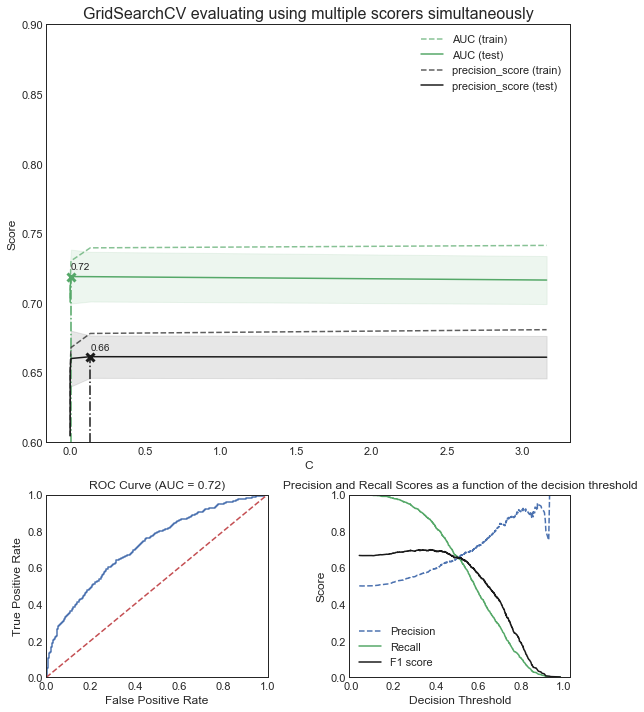

In [37]:
# --------------------------
# Search through the parameter grid and return the best model for each type
# -------------------------- 
logistic_best = trial_model(Logistic)

--------------------------
RandomForest
--------------------------
Best params for AUC
{'max_features': 5, 'min_samples_split': 9}
Best score: 0.72
Range 0.72 0.71

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,690,310
pos,370,630



Classification report for best model:
             precision    recall  f1-score   support

          0       0.65      0.69      0.67      1000
          1       0.67      0.63      0.65      1000

avg / total       0.66      0.66      0.66      2000



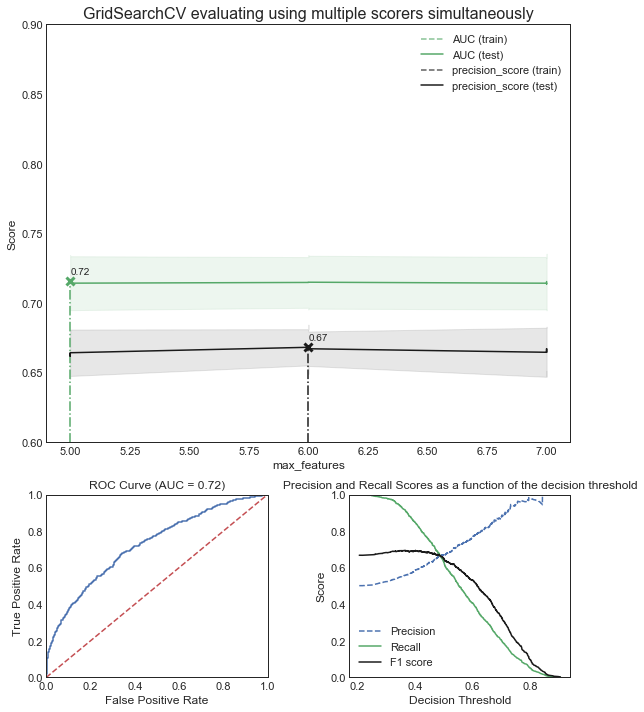

In [38]:
# RF takes a while to run, especially if the grid is large so be careful about adding too many parameters
rf_best = trial_model(RandomForest, param_to_plot = "max_features")

--------------------------
Adaboost
--------------------------
Best params for AUC
{'n_estimators': 50}
Best score: 0.71
Range 0.71 0.7

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,662,338
pos,359,641



Classification report for best model:
             precision    recall  f1-score   support

          0       0.65      0.66      0.66      1000
          1       0.65      0.64      0.65      1000

avg / total       0.65      0.65      0.65      2000



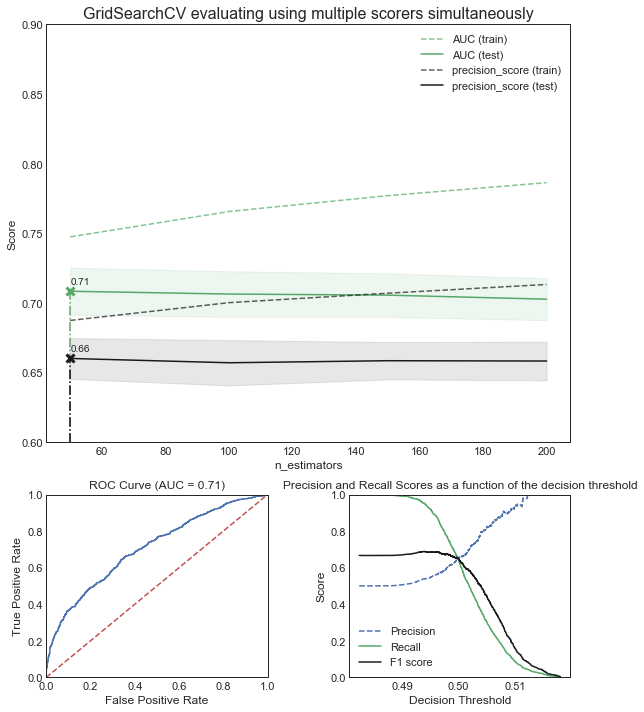

In [39]:
ada_best = trial_model(AdaBoost)

--------------------------
Gradient
--------------------------
Best params for AUC
{'max_features': 0.5}
Best score: 0.71
Range 0.71 0.71

Confusion matrix of model optimized for AUC on the test data:


,pred_neg,pred_pos
neg,661,339
pos,339,661



Classification report for best model:
             precision    recall  f1-score   support

          0       0.66      0.66      0.66      1000
          1       0.66      0.66      0.66      1000

avg / total       0.66      0.66      0.66      2000



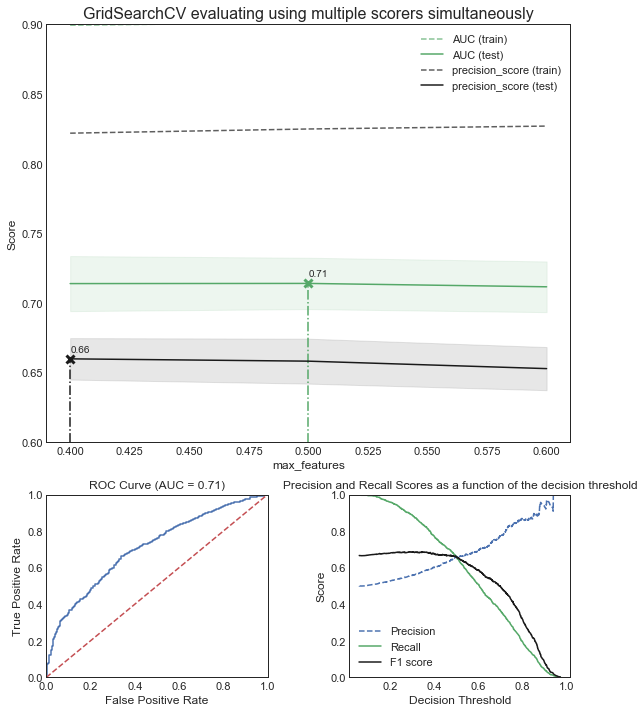

In [40]:
grad_best = trial_model(Gradient)

<div class='exercise'><b> Part 5: Model comparisons </b></div>

This section develops a function to compare the performance metrics for all of the best models found in part 4

In [42]:
# --------------------------
# List of best models from the previous tuning step
# -------------------------- 
model_dict = {"Logistic": logistic_best,
              "Random Forest": rf_best,
              "Adaboost": ada_best,
              "Gradient": grad_best
            }

In [43]:
# --------------------------
# Function to generate comparisons of the best models of each type
# -------------------------- 
def compare_models(model_dict): 

    cols = ["model", "roc_auc_score", "accuracy_score", "precision_score", "recall_score", "f1_score"]
    models_report = pd.DataFrame(columns = cols)
    
    plt.figure(figsize = (6, 6))

    for clf, clf_name in zip(model_dict.values(), model_dict.keys()):
        # --------------------------
        # Create a dataframe with the performance metrics
        # -------------------------- 
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_prob = clf.predict_proba(X_test)[:,1]
        
        report = pd.Series({"model": clf_name,
                         "roc_auc_score" : roc_auc_score(y_test, y_test_pred_prob),
                         "accuracy_score": accuracy_score(y_test, y_test_pred),
                         "precision_score": precision_score(y_test, y_test_pred),
                         "recall_score": recall_score(y_test, y_test_pred),
                         "f1_score": f1_score(y_test, y_test_pred)})
        
        models_report = models_report.append(report, ignore_index = True)
        
        # --------------------------
        # Generate all the ROC curves on the same plot
        # -------------------------- 
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob, drop_intermediate = False, pos_label = 1)
        
        # Plot 
        plt.plot(fpr, tpr, label = clf_name, alpha = 0.8)
    plt.title("ROC Curves")
    plt.legend(loc = 2)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.plot([0,1], [0,1], "r--")
    plt.title("ROC Curves")
    plt.show();
    
    return models_report


### Comparison of the best models

As can be seen from below, the different classifiers do not perform that differently (at least for the parameters tried so far). 

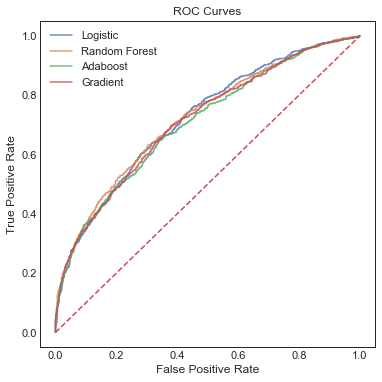

,model,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
0,Logistic,0.719838,0.6535,0.651530,0.660,0.655738
1,Random Forest,0.721175,0.6630,0.673774,0.632,0.652219
2,Adaboost,0.707566,0.6515,0.654750,0.641,0.647802
3,Gradient,0.713090,0.6550,0.656250,0.651,0.653614


In [44]:
# Run the function above to compare all of the best models
models_report = compare_models(model_dict = model_dict)
models_report

In [45]:
y_test_pred = rf_best.predict(X_test.values)

A comparison of the feature importance for the random forest and gradient boosting shows that they are selecting similar features in the top 10, although with slightly different weights/ordering.

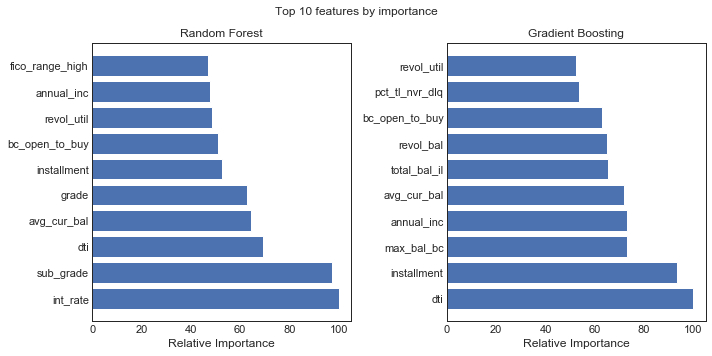

In [46]:
def feature_importance_plot(model, title, ax, num_to_plot = 10):
    # Find feature importance
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(-feature_importance)[0: num_to_plot]
    pos = np.arange(sorted_idx.shape[0]) + .5

    # Plot
    ax.barh(pos, feature_importance[sorted_idx], align = "center")
    ax.set_yticks(pos)
    ax.set_yticklabels(X_test.columns[sorted_idx])
    ax.set_xlabel("Relative Importance")
    ax.set_title(title)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

feature_importance_plot(model_dict["Random Forest"], "Random Forest", ax = ax1)
feature_importance_plot(model_dict["Gradient"], "Gradient Boosting", ax = ax2)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Top 10 features by importance");


<div class='exercise'><b> Part 6: Tuning the preferred model </b></div>

### Model selection

In this part, we explore the random forest model in more depth. This is because all of the models explored above perform fairly similarly in terms of the metrics, but the random forest has a slightly better overall AUC. 

### Tuning for better precision

We can use the `class_weight` parameter in sklearn to modify the loss function so that it penalises false positives more. If the weight for a class is large, the classifier is more likely to predict data to be in that class

In [70]:
rf_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
# Weighting of 10
rf_weighted = RandomForestClassifier(class_weight = {0:3},
                                    max_depth=15, max_features=5, min_samples_split=9,n_estimators=400, n_jobs=-1).fit(X_train, y_train)

y_test_pred = rf_weighted.predict(X_test.values)
CM = (pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                     columns=["pred_neg", "pred_pos"], index=["neg", "pos"]))
display(CM)

,pred_neg,pred_pos
neg,923,77
pos,675,325


In [17]:
# Weighting of 3
rf_weighted = RandomForestClassifier(class_weight = {0:10},
                                    max_depth=15, max_features=5, min_samples_split=9,n_estimators=400, n_jobs=-1).fit(X_train, y_train)

y_test_pred = rf_weighted.predict(X_test.values)
CM = (pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                     columns=["pred_neg", "pred_pos"], index=["neg", "pos"]))
display(CM)

,pred_neg,pred_pos
neg,981,19
pos,880,120


### Adjusting thresholds
An alternative way to do the final tuning is to adjust the decision thresholds.  The code below maximises the precision metric, but this results in very few positive predictions overall (i.e. true positives are reduced as well as false positives). 

In [18]:
# --------------------------
# Find the best thresholds to maximise precision and F1 scores
# --------------------------
best_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False).fit(X_train, y_train)

# --------------------------
# Retrieve predicted probabilities for the best model &
# Get performance for different thresholds
# --------------------------
y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
F1 = 2*((p*r)/(p+r))

best_threshold_index = np.argmax(p) 
best_threshold_precision = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]

print("Threshold that maximises precision is:")
print(best_threshold_precision)


Threshold that maximises precision is:
0.8308530887429041


In [19]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


In [20]:
# Calculate new predicted values using the threshold that maximises precision
y_adjusted = adjusted_classes(y_test_pred_prob, 
                              t = best_threshold_precision)

print(pd.DataFrame(confusion_matrix(y_test, y_adjusted),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

     pred_neg  pred_pos
neg      1000         0
pos       977        23


### Explore fairness: age

We assume that the earliest credit line is a good proxy for age. If we assume that people get their first line of credit at about 18 years old, the distribution of age in our dataset is shown below

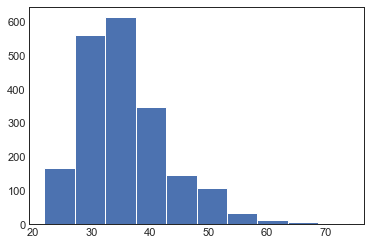

In [21]:
# Explore age distribution in the test set
Age = 2018 - np.array(earliest_credit) + 18 # Assume earliest credit was obtained at 18 years old
plt.hist(Age);

In [45]:
# --------------------------
# Create a custom scoring function that calculates fairness metrics
# -------------------------- 
def fairness_report(y_test, y_test_pred, protected_class):
    """Adapted from IBM360 Research.
        Calculates various fairness metrics:
        
        - Equal opportunity: Return the ratio of true positives to positive examples `TPR = TP/P`
        - Predictive equality: We define the predictive equality as the situation when accuracy 
        of decisions is equal across race groups, as measured by false positive rate (FPR). 
        - Statistical parity: Statistical parity denotes an equal proportion of each protected category in question are positively classified
        
        Returns: Metric differences between priviliged and unpriviliged groups:
        Equal opportunity, Predictive equality, Statistical parity
    """
    results = {}
    
    # Recoded to work with series
    protected = np.where(protected_class == 1) # Select protected class
    not_protected = np.where(protected_class == 0) # Select unprotected class
    
    # --------------------------
    # Calculate metrics for protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[protected], y_test_pred[protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP
    
    TPR_protected = TP / P
    FPR_protected = FP / N
    Parity_protected = (TP + FP) / len(y_test.values[protected])
    
    # --------------------------
    # Same for un-protected class
    # --------------------------  
    CM = confusion_matrix(y_test.values[not_protected], y_test_pred[not_protected])
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    P = TP + FN
    N = TN + FP    
    
    TPR = TP / P
    FPR = FP / N
    Parity = (TP + FP) / len(y_test.values[not_protected])
    
    results = {"equal_opportunity": np.round(TPR_protected - TPR, 3),
               "predictive_equality": np.round(FPR_protected - FPR, 3),
               "statistical_parity": np.round(Parity_protected - Parity, 3)
        
    }
    
    return pd.Series(results)
    

In [46]:
# Define over 50 as protected class
Over_50 = np.array((Age >=50)*1)

In [47]:
# Fairness for best model
y_test_pred = best_model.predict(X_test.values)

fairness = fairness_report(y_test, y_test_pred, 
                                  protected_class = Over_50)
fairness

equal_opportunity     -0.009
predictive_equality   -0.043
statistical_parity    -0.017
dtype: float64

In [48]:
# And testing using the weighted model
y_test_pred = rf_weighted.predict(X_test.values)

fairness = fairness_report(y_test, y_test_pred, 
                                  protected_class = Over_50)
fairness

equal_opportunity      0.131
predictive_equality    0.015
statistical_parity     0.078
dtype: float64

This shows that adjusting the threshold to reduce false positives changes the fairness from slightly biased against people over 50, to slightly positively favouring people aged over 50.

### Next steps:
* Could Oyvind add a function to calculate investor return on the model predictions and adjust the threshold to maximise this? 
* Someone to add fairness binary indicators from census data - e.g. proportion of blacks?
* Roland to work on website?